# **Modello di Machine Learning per il cross-selling di polizze assicurative**
Il presente progetto realizzato da me, Alessio Feudo nell'ambito del master in Data Science erogato da Profession AI, tratta la creazione di un modello di machine learning per il cross-selling di polizze assicurative. In particolare, si vuole studiare il caso di clienti della società assicurativa 'AssurePredict' già in possesso di una polizza sanitaria, sondando la loro inclinazione a volerne attivare una ulteriore per la propria automobile.
Per raggiungere tale obiettivo, sarà allenato un modello di regressione logistica in grado di prevedere l'inclinazione del cliente con una certa probabilità. Per la realizzazione di tale modello, sono indagate varie relazioni funzionali polinomiali e vari metodi per tenere conto dello sbilanciamento della variabile target, come la creazione di nuovi samples per rendere più numerosa la classe positiva oppure pesare in modo diverso le classi in base alla loro numerosità. Entrambe le modalità verranno infine confrontate su nuovi dati inediti. La realizzazione del porgetto attraversa diverse fasi: esplorazione dataset, ricerca del modello migliore, valutazione con opportune metriche e conclusioni.

Il dataset utilizzato contiene informazioni sui clienti della società 'AssurePredict' indicando quanti di loro avendo già un'assicurazione sanitaria, hanno anche sottoscritto una polizza assicurativa sul loro veicolo. In particolare le variabili presenti sono:

*    id: identificativo univoco del cliente.
*    Gender: sesso del cliente.
*    Age: età del cliente.
*    Driving_License: 1 se il cliente possiede la patente di guida, 0 altrimenti.
*    Region_Code: codice univoco della regione di residenza del cliente.
*    Previously_Insured: 1 se il cliente ha già un veicolo assicurato, 0 altrimenti.
*    Vehicle_Age: età del veicolo del cliente.
*    Vehicle_Damage: 1 se il cliente ha avuto incidenti o danni al veicolo in passato, 0 altrimenti.
*    Annual_Premium: importo annuale del premio assicurativo pagato dal cliente.
*    PolicySalesChannel: canale utilizzato per la vendita della polizza (es. email, telefono, di persona).
*    Vintage: giorni da cui il cliente è assicurato con AssurePredict.
*    Response: 1 se il cliente ha accettato la proposta di cross-sell, 0 altrimenti.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# si carica il dataset
df_ini=pd.read_csv('https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv')
# si trascura la colonna con l'id identificativo del cliente, essendo superflua in algoritmi di ML.
df_ini=df_ini.drop('id', axis=1)

## **1. Esplorazione del Dataset**

Come primo passo si esplora il dataset, analizzando le varie features e il target del modello finale, cioè 'Response'.

   Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age  \
0    Male   44                1         28.0                   0   > 2 Years   
1    Male   76                1          3.0                   0    1-2 Year   
2    Male   47                1         28.0                   0   > 2 Years   
3    Male   21                1         11.0                   1    < 1 Year   
4  Female   29                1         41.0                   1    < 1 Year   

  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response  
0            Yes         40454.0                  26.0      217         1  
1             No         33536.0                  26.0      183         0  
2            Yes         38294.0                  26.0       27         1  
3             No         28619.0                 152.0      203         0  
4             No         27496.0                 152.0       39         0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entr

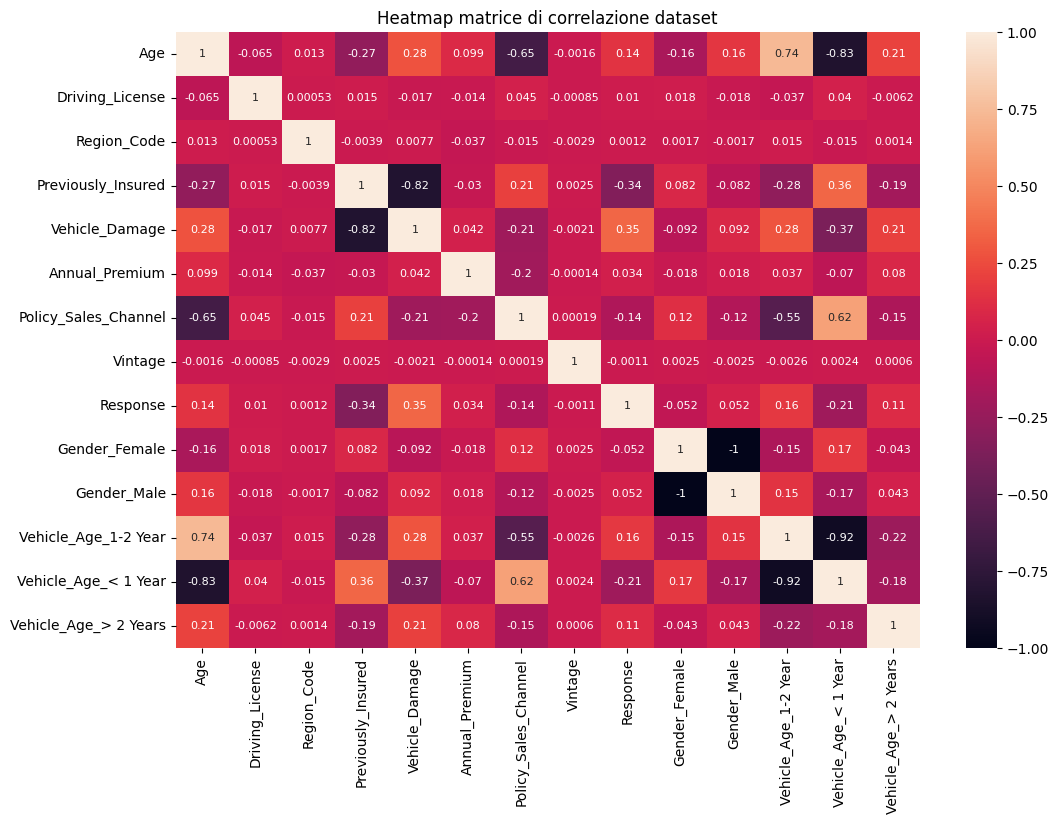

In [ ]:
# si genera una copia del dataset originale così da non alterarlo durante le manipolazioni
df=df_ini.copy()

# si stampano le prime righe di dati, i tipi delle features e gli indicatori statistici principali relativi alle features numeriche,
# nonchè i conteggi delle varie classi per le variabili categoriche.
print(df.head(), '\n')
print(df.info(), '\n')

# check su eventuali dati mancanti nel dataset
print(f"Controllo dati mancanti: \n{df.isna().sum()}\n")

# si dividono le variabili in numeriche e qualitative
qual_var=['Gender', 'Driving_License', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code','Previously_Insured', 'Policy_Sales_Channel','Response']
num_var=['Age','Annual_Premium','Vintage']

# statistica variabili numeriche
for col in num_var:
  print(f"{col}: {df[col].describe()}\n")
  print(f"skewness {col}: {df[col].skew():.3f}\nkurtosis {col}: {df[col].kurtosis():.3f}\n\n")

# conteggi classi variabili qualitative
for col in qual_var:
  print(df[col].value_counts(), "\n")

# Feature encoding
#one-hot encodig su gender e vehicle age. Su quest'ultima si sceglie OHE e non label encoding perchè la 'distanza' tra le classi non è costante.
df=pd.get_dummies(df, columns=['Gender','Vehicle_Age'])
damage_map={'Yes':1, 'No':0} # mappa per codifica variabile Vehicle_Damage
df['Vehicle_Damage']=df['Vehicle_Damage'].map(damage_map)
print(f"Dataset codificato: \n{df.head()}\n")

# Matrici di correlazione
print(f"Correlazione tra Response e features \n{round(df.corr(method='spearman')['Response'],2)}") # correlazione di Spearman tra Response e features

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True, annot_kws={'size':8}, fmt='.2g') # Heatmap matrice di correlazione tra tutte le variabili del dataset
plt.title('Heatmap matrice di correlazione dataset')
plt.show()

In [ ]:
# analisi dei dati aventi risposta positiva per osservare la presenza di tendenze
df_pos=df[df['Response']==1]
columns=['Gender_Male', 'Driving_License', 'Vehicle_Age_< 1 Year', 'Vehicle_Age_1-2 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage', 'Region_Code','Previously_Insured', 'Policy_Sales_Channel']

# stessa analisi fatta nel dataset completo precedentemente
for item in columns:
  print(df_pos[item].value_counts(), '\n')

for item in num_var:
  print(f"{item}: {df[item].describe()}\n")

Gender_Male
True     28525
False    18185
Name: count, dtype: int64 

Driving_License
1    46669
0       41
Name: count, dtype: int64 

Vehicle_Age_< 1 Year
False    39508
True      7202
Name: count, dtype: int64 

Vehicle_Age_1-2 Year
True     34806
False    11904
Name: count, dtype: int64 

Vehicle_Age_> 2 Years
False    42008
True      4702
Name: count, dtype: int64 

Vehicle_Damage
1    45728
0      982
Name: count, dtype: int64 

Region_Code
28.0    19917
8.0      3257
41.0     2224
46.0     2032
29.0     1365
3.0      1181
11.0     1041
15.0      958
30.0      900
35.0      865
33.0      760
36.0      703
18.0      678
47.0      652
50.0      642
45.0      615
39.0      574
48.0      477
6.0       439
37.0      436
7.0       432
14.0      422
38.0      389
13.0      364
24.0      342
12.0      312
21.0      303
23.0      300
2.0       287
4.0       285
10.0      263
9.0       253
19.0      250
43.0      244
32.0      239
20.0      223
27.0      209
31.0      197
26.0      187
17.

Dall'analisi esplorativa iniziale si possono notare alcune caratteristiche importanti ai fini di indagine.

*   L'età dei clienti è compresa tra 20 e 85 anni, con il 75% dei clienti sotto i 50 anni. I clienti sono a prevalenza maschile, con circa 31 000 unità di differenza tra i due sessi.
*   La stragrande maggioranza dei clienti possiede una licenza di guida, il che potrebbe suggerire buone possibilità di avere un'automobile da assicurare.
*   La maggior parte dei clienti possiede veicoli relativamente nuovi, tra meno di 1 anno o tra 1 e 2 anni di età, il che potrebbe condurli ad essere più inclini a volerlo assicurare. Inoltre più del 50% dei clienti ha subito danni al proprio veicolo in passato e non è già assicurato.
*   Circa un quarto dei clienti vive nella regione con codice identificativo 28.
*   Il 75% dei clienti paga un premio assicurativo annuale inferiore a 40 000 euro, con una media di circa 30 500 euro all'anno. La distribuzione è asimmetrica positiva.
*   Il numero di giorni da cui i clienti sono tali per la società mostra una media di circa 154 giorni, valore molto vicino a quello della mediana, indicando una buona simmetria nella distribuzione della feature, confermato anche dal coefficiente di asimmetria.
*   Più di un quarto delle polizze è proposta al cliente utilizzando il canale di vendita 152.
*   Relativamente al successo della vendita della polizza auto, visualizzando la variabile 'Response' si nota come la stragrande maggioranza dei clienti abbia rifiutato l'acquisto. Questa sovrabbondanza di no rispetto ai sì andrà poi mitigata per costruire il modello predittivo finale.


Dalla Heatmap della matrice di correlazione tra le variabili del dataset, si può studiare quali features influenzano maggiormente il target 'Response' e quali sono correlate tra loro. Si sceglie di utilizzare il coefficiente di correlazione di Spearman perchè più generale e adatto a casi di andamenti non lineari tra le variabili.
Dalle correlazioni si evince che:

*   'Annual_premium' risulta molto poco correlata al target e alle altre features, con unica eccezione per la features 'Policy_Sales_Channel'.
*   'Vehicle_Age' mostra una forte correlazione con l'età del cliente per la classe 1-2 anni, mentre anticorrelazione per la classe < 1 anno. Si nota una debole correlazione postiva con il target tranne che per l classe < 1 anno che risulta anticorrelata. La variabile risulta anticorrelata con 'Policy_Sales_Channel' e 'Previously_Insured', ad eccezione della classe < 1 anno, che in entrambi i casi risulta correlata positivamente. Si nota anche una correlazione positiva con 'Vehicle_Damage', sempre con l'eccezioe per la classe < 1 anno che risulta anticorrelata. Si può inoltre notare una debole correlazione positiva e negativa (sempre con la classe < 1 anno con comportamento opposto alle altre due) con il Gender.
*   'Previously_Insured' risulta debolmente anticorrelata all'età del cliente, e correlata/anticorrelata (sempre classe < 1 anno opposta alle altre) all'età del veicolo. Risulta molto anticorrelata con 'Vehicle_Damage'. Infine si nota una debole anticorrelazione con il target e correlazione positiva con 'Policy_Sales_Channel'.

In conclusione, la variabile target 'Response' risulta maggiormente influenzata dalle variabili 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage' e solo blandamente da 'Age' e 'Policy_Sales_Channel'. La correlazione con le restanti features risulta trascurabile.

Infine, tra le features stesse le correlazioni maggiori si registrano tra 'Vehicle_Damage'-'Previously_Insured', 'Vehicle_Age'-'Policy_Sales_Channel', 'Policy_Sales_Channel'-'Age' e 'Vehicle_Age'-'Age'.

In aggiunta a questa analisi generale, si è studiata anche la distribuzione delle variabili limitatamente alla risposta positiva al cross-sell. Si è trovato che i clienti aderenti al cross-sell sono in maggioranza uomini, hanno avuto danni alla loro auto che ha in prevalenza tra 1 e 2 anni, provengono in prevalenza dalla regione con codice 28, non erano precedentemente assicurati e hanno acquistato la polizza prevalentemente tramite i canali 26 e 124.


## **2. Creazione modello**
Si procede alla creazione di un modello di Machine Learning per prevedere la probabilità che un cliente risponda positivamente all'offerta di cross-sell.
Essendo 'Response' (variabile target) una variabile categoriale binaria, si implementa una Regressione Logistica, cioè un modello di classificazione che rientra nell'apprendimento supervisionato e che calcolerà la probabilità di acquisto della polizza stanti certi valori delle varie features. Per costruire un modello robusto, si dividerà il dataset inizale in una porzione usata per il training del modello, una per la validazione (e quindi il tuning dei parametri) e una porzione per il test. L'uso del set di validazione aiuta a prevenire data leakage, andando a fare il test finale su un insime di dati mai visti dal modello (il set di test). Al termine del tuning dei parametri si testa quindi il modello sul set di test e infine si riallena su tutto il dataset al completo, pronto per essere poi messo in produzione. Inoltre per cogliere la presenza di eventuali nonlinearità, si testeranno vari gradi polinomiali per i coefficienti. In tal senso, stante la grande quantità di dati e il crescente numero di features con il grado del polinomio, si sceglie la tecnica dell'Hold-out invece della Cross Validation che risulterebbe computazionalmente più dispendiosa, relegando la sua implementazione solo per la learning curve.
Il modello includerà solo le feature maggiormente correlate al target, viste nella precedente analisi. Questo sia per non aggiungere informazione superflua e appesantire il modello a livello computazionale, sia per privilegiare un modello più semplice e interpretabile. Si valuterà anche la presenza di overfitting e si procederà alla regolarizzazione.
### 2.1. Selezione modello migliore con lo SMOTE
 Dai risultati della sezione di analisi del dataset, si è visto come la variabile target 'Response' sia sbilanciata, con molte occorrenze per il no e poche per il sì. Per affrontare questa condizione si valutano due approcci differenti: il bilanciamento delle classi con SMOTE, che agisce sui dati, e il 'class weight', che agisce a livello di funzione di costo. Per il momento si considera solo l'approccio SMOTE, che crea nuovi samples per la classe minoritaria portando ad un dataset di trainig bilanciato. In tal senso, lo SMOTE è una possibile causa di overfitting per il modello, per questo motivo, per selezionare il miglior modello, si usa una funzione apposita che valuterà l'accuratezza di ogni modello al variare del grado di polinomio e inverso del coefficiente di regolarizzazione, scegliendo la combinazione dei due parametri migliore.

grado: 1, c: 1000
f1: 0.3983195
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222

grado: 1, c: 1.0
f1: 0.3983195
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222

grado: 1, c: 0.1
f1: 0.3983195
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78 

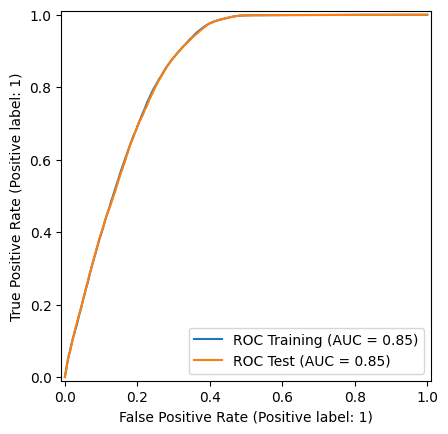

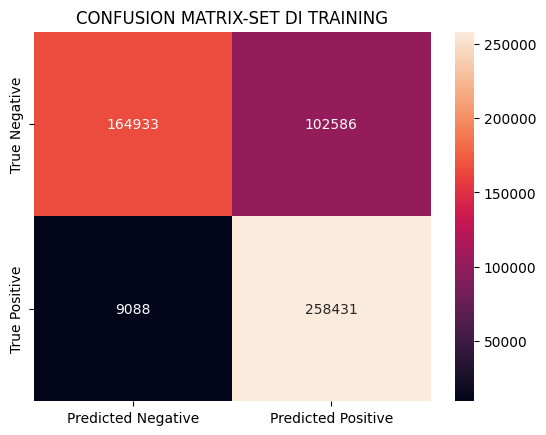

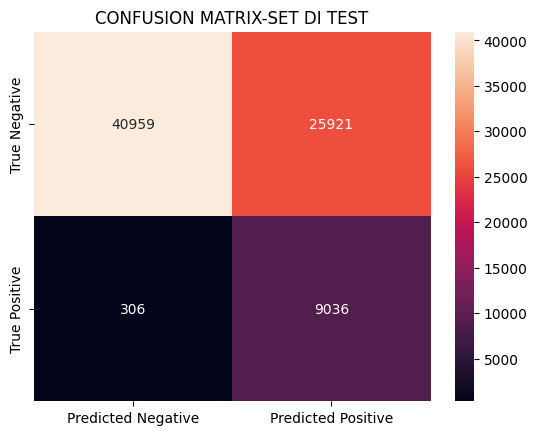

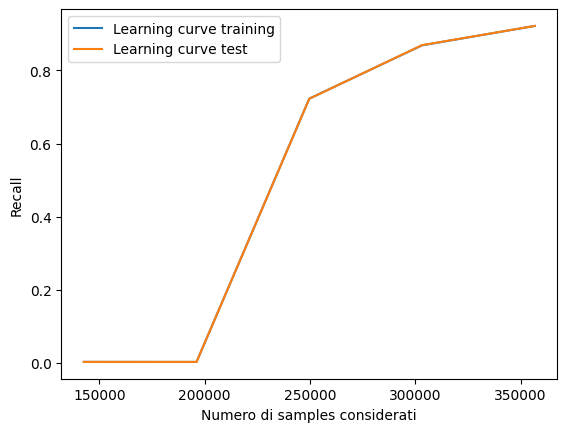

LogisticRegression(C=0.01, max_iter=5000)

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, log_loss, f1_score
from sklearn.model_selection import learning_curve, train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE


def confusion(y_true, y_pred, name):
  '''
  Questa funzione fa il grafico della confusion matrix per il modello (che entra in y_pred, cioè y predetto dal modello)
  '''
  cm=confusion_matrix(y_true, y_pred)
  # si trasforma la confusion matrix in dataframe
  df_cm=pd.DataFrame(cm, index=['True Negative','True Positive'], columns=['Predicted Negative','Predicted Positive'])
  # si plotta la relativa heatmap con seaborn
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(f"CONFUSION MATRIX-{name}")
  plt.show()


def evaluate_model(model, x_train, x_test, y_train, y_test):
  '''
  Questa funzione si occupa di valutare la performance di un modello di regressione logistica usando:
         -classification report
         -ROC
         -log loss
         -confusion matrix
         -learning curve
  '''

  # Predizioni di probabilità del modello su trainig e test
  y_prob_train=model.predict_proba(x_train)
  y_prob_test=model.predict_proba(x_test)

  # Predizioni del modello su set di training e test
  y_pred_train=np.where(y_prob_train[:,1]>0.40,1,0)   #si usa una soglia minore di 0.5 per evitare troppi falsi negativi, a scapito dei falsi positivi.
  y_pred_test=np.where(y_prob_test[:,1]>0.40,1,0)


  # Calcolo della log_loss e classification report per trainig e test
  print(f"Log_loss_train: {round(log_loss(y_train, y_prob_train),3)}\nLog_loss_test: {round(log_loss(y_test, y_prob_test),3)}\n")
  print(f"CLASSIFICATION REPORT TRAINING: \n{classification_report(y_train, y_pred_train)}")
  print(f"CLASSIFICATION REPORT TEST: \n{classification_report(y_test, y_pred_test)}")

  # Plot della ROC per trainig e test
  fig, ax = plt.subplots() #si crea un grafico sovrapposto per train e test, passando lo stesso asse ax ai due.
  roc_train=RocCurveDisplay.from_estimator(model, x_train, y_train, ax=ax, name='ROC Training')
  roc_test=RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax, name='ROC Test')
  plt.show()

  # Confusion Matrix
  confusion(y_train, y_pred_train, 'SET DI TRAINING') # chiamata alla funzione precedente per la confusion matrix
  confusion(y_test, y_pred_test, 'SET DI TEST')

  # Learning curve
  # StratifiedKFold serve a creare i folds per cross validation facendo si che in ogni fold la distribuzione delle classi del target rispecchi
  # quella del dataset completo, per evitare che in alcuni folds vi sia solo una delle due classi.
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)
  train_sizes = np.linspace(0.4, 1.0, 5) #la learning curve valuterà il modello su 5 sottoinsiemi dei dati crescenti in numerosità.
  train_size_abs, train_scores, test_scores=learning_curve(model,
                                                           x_train,
                                                           y_train,
                                                           cv=cv,
                                                           train_sizes=train_sizes,
                                                           n_jobs=-1,
                                                           scoring='recall', # la lerning curve si baserà sul recall
                                                           error_score='raise',
                                                           )

  plt.xlabel('Numero di samples considerati')
  plt.ylabel('Recall')
  plt.plot(train_size_abs, train_scores.mean(axis=1), label='Learning curve training')
  plt.plot(train_size_abs, test_scores.mean(axis=1), label='Learning curve test')
  plt.legend()
  plt.show()



def preprocess(x_train, x_test=None, standardize=False, polynomial_deg=1):

  '''
  Questa funzione applica trasformazioni sulle features che includono:
        -standardizzazione
        -features polinomiali di grado >=2
  Le features di test non sono presenti nell'addestramento finale del modello, per questo si settano di default a None
  La funzione ritorna le features trasformate e i trasformatori.
  '''
  poly_out=None  #variabili che conterranno i trasformatori del modello per output, così da poterli poi riutilizzare su nuovi dati futuri
  ss_out=None
  # il trasforatore polinomiale è attivato solo se il grado in input è maggiore di 1 (Questo anche per come è costruita la funzione in sklearn)
  if polynomial_deg>1:
      poly=PolynomialFeatures(polynomial_deg)
      x_train=poly.fit_transform(x_train) # la trasformazione è calcolata e applicata sul train e solo applicta sul test
      if x_test is not None:
          x_test=poly.transform(x_test)
      poly_out=poly

  if standardize==True:
      ss=StandardScaler()
      x_train=ss.fit_transform(x_train) # la trasformazione è calcolata e applicata sul train e solo applicta sul test
      if x_test is not None:
          x_test=ss.transform(x_test)
      ss_out=ss

  return x_train, x_test, poly_out, ss_out



def best_model_searcher(x_train, x_val, y_train, y_val, smote):
  '''
  Funzione che si occupa di cercare il modello migliore confrontando l'f1 score per vari gradi di polinomio e per vari coefficienti di regolarizzazione.
  In output ritorna grado del polinomio e inverso del coefficiente di regolarizzazione migliori.
  '''
  #si creano due variabili che conterranno i valori di grado di polinomio e regolarizzazione per il modello migliore
  deg_best=None
  c_best=None

  f1_best=0.  #si inizializza f1_best a 0. Di volta in volta sarà aggiornato fino al modello migliore dove avrà valore massimo.
  degrees=range(1,5) #gradi di polinomio testati
  c_list=[1000, 1.0, 0.1, 0.01] # inverso dei coefficienti di regolarizzazione (alto valore: poca regolarizzazione)

  for i, d in enumerate(degrees): #ciclo sui gradi di polinomio

      x_train_transf, x_val_transf, _, _ = preprocess(x_train, x_val, standardize=True, polynomial_deg=d) #preprocessing dei dati
      #nota: lo smote è istanziato fuori dalla funzione e passato come argomento
      #smote si applica solo sul training set
      x_train_smote, y_train_smote=smote.fit_resample(x_train_transf, y_train)

      for j, c_value in enumerate(c_list): #ciclo sui coefficienti di regolarizzazione

          lr=LogisticRegression(penalty='l2', C=c_value, max_iter=5000)  #si istanzia il modello e si include la regolarizzazione 'Ridge'
          lr.fit(x_train_smote, y_train_smote) # si allena il modello

          y_val_pred=lr.predict(x_val_transf) # si prevedono le classi sul set di test con il modello

          test_f1=f1_score(y_val, y_val_pred) # si valuta l'f1 sul set di validazione

          if test_f1>f1_best: # se f1 calcolato è maggiore di quello di riferimento (che all'inizio è 0) si aggiorna e si salva il modello come migliore
            f1_best=test_f1
            deg_best=d
            c_best=c_value

          # si valuta il modello i-esimo sul set di validazione
          print(f"grado: {d}, c: {c_value}")
          print(f"f1: {test_f1:.7f}")
          print(classification_report(y_val, y_val_pred))

  #alla fine della ricerca si stampano il grado e il coefficiente di regolarizazione del modello migliore.
  print(f"Il grado di polinomio più adatto è: {deg_best}\nIl coefficiente c più adatto è: {c_best}\n")

  return deg_best, c_best

###################################  MAIN  ###############################################


# selezione delle features e del target
x=df[['Age', 'Previously_Insured', 'Vehicle_Age_< 1 Year', 'Vehicle_Age_1-2 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage', 'Policy_Sales_Channel']].values
# per features si considerano solo feature significative
y=df['Response'].values


#Divisione del dataset in set di trainig, validazione e set di test tramite 'Hold out'
#si assegna il 20% a test e validazione e il 60 al training
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2, stratify=y)
# stratify aiuta i vari gruppi di dati ad avere stessa proporzione di classi di y originale
x_train_partial, x_val, y_train_partial, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=2, stratify=y_train)


smote=SMOTE(random_state=2)  #si istanzia lo SMOTE
#chiamata alla funzione di ricerca del modello migliore
deg, c = best_model_searcher(x_train_partial, x_val, y_train_partial, y_val, smote)


# una volta ottenuto il modello migliore si riallena su tutto il train+val set e si valuta sul set di test
x_train_transf, x_test_transf, _, _= preprocess(x_train, x_test, standardize=True, polynomial_deg=deg)
x_train_smote, y_train_smote=smote.fit_resample(x_train_transf, y_train)
lr_best=LogisticRegression(penalty='l2', C=c, max_iter=5000)
lr_best.fit(x_train_smote, y_train_smote)
print("\n\nMODELLO MIGLIORE CON SMOTE\n")
evaluate_model(lr_best, x_train_smote, x_test_transf, y_train_smote, y_test)


# si riaddestra il modello su tutto il set di training per predizioni successive, salvando anche i trasformatori a lui associati
x_transf,_ , poly_smote, ss_smote= preprocess(x, standardize=True, polynomial_deg=deg)
x_smote, y_smote=smote.fit_resample(x_transf, y)

lr_smote=LogisticRegression(penalty='l2', C=c, max_iter=5000)
lr_smote.fit(x_smote, y_smote)




Per estrarre il modello migliore sui vari gradi di polinomio e sui vari valori dell'inverso del coefficiente di regolarizzazione, si stima l'F-1, che consiste in una media pesata tra precisione(% di classificazioni positive che lo erano davvero) e recall(% di osservazioni positive classificate tali). Il modello con F-1 maggiore sarà quello da preferire. Dopo aver selezionato il grado di polinomio 3 e l'inverso del coefficiente di regolarizzazione 0.01 che ottimizzano le performance sul set di validazione, si procede ad allenare il modello su train+validazione e ad analizzarlo con opportune metriche sul set di test. A causa della volontà di ridurre il numero di falsi negativi si sceglie una soglia di 0.4, minore della classica soglia pari a 0.5. In tal modo si ottiene un recall maggiore, a scapito della precisione nella valutazione del modello. Inoltre, essendo la variabile risposta sbilanciata in favore della classe negativa, oltre allo SMOTE usato nella fase di selezione del modello migliore, nella sezione successiva si cerca di mitigare tale problema testando anche il 'class weight', che invece non agisce direttamente sui dati, ma sulla funzione di costo del modello, assegnando peso maggiore ai samples della classe minoritaria. In generale, tali correzioni sono necessarie in quanto un dataset sbilanciato porta il modello ad 'imparare' la risposta più comune (in questo caso la classe negativa) invece di imparare a dedurla dalle features di ogni dato.



MODELLO CON CLASS WEIGHT

Log_loss_train: 0.474
Log_loss_test: 0.479

CLASSIFICATION REPORT TRAINING: 
              precision    recall  f1-score   support

           0       0.99      0.61      0.76    267519
           1       0.26      0.97      0.41     37368

    accuracy                           0.66    304887
   macro avg       0.63      0.79      0.58    304887
weighted avg       0.90      0.66      0.72    304887

CLASSIFICATION REPORT TEST: 
              precision    recall  f1-score   support

           0       0.99      0.61      0.76     66880
           1       0.26      0.97      0.41      9342

    accuracy                           0.65     76222
   macro avg       0.63      0.79      0.58     76222
weighted avg       0.90      0.65      0.71     76222



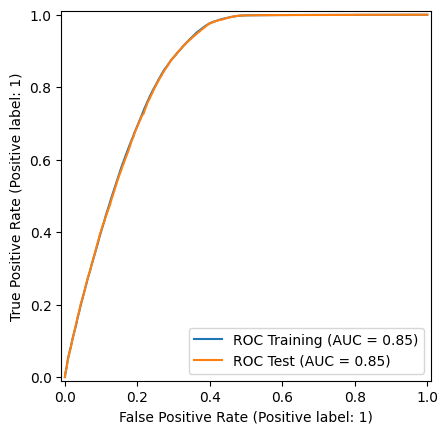

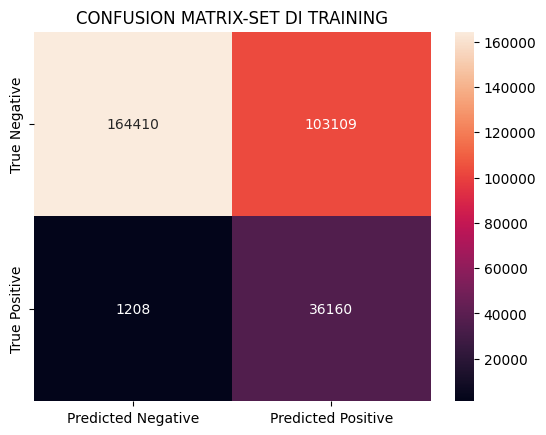

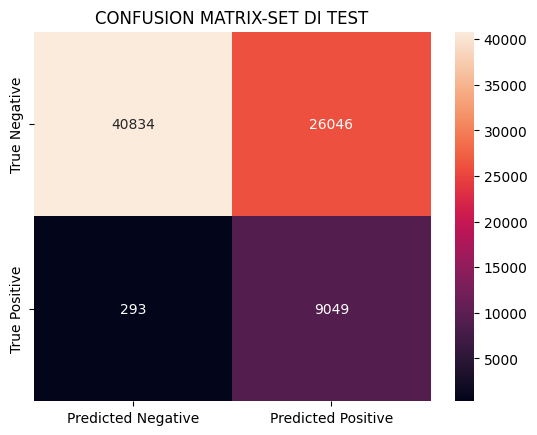

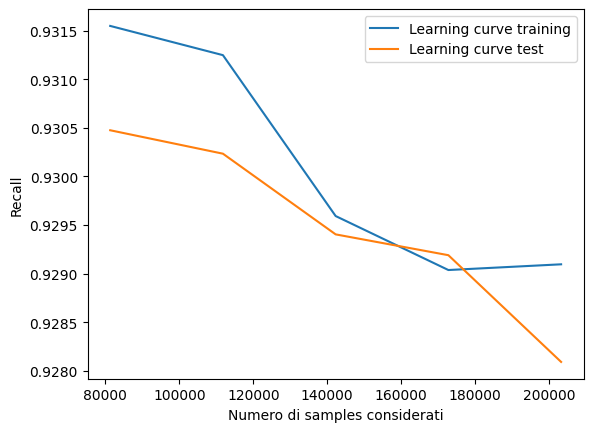

LogisticRegression(class_weight='balanced', max_iter=5000)

In [ ]:
# Modello con class weight
x_train_transf, x_test_transf, _, _= preprocess(x_train, x_test, standardize=True, polynomial_deg=deg)

#il modello con class weight non mostrando overfitting, non viene regolarizzato
lr_class=LogisticRegression(class_weight='balanced', max_iter=5000) #class_weight='balanced' applica il peso diverso sulle classi in fase di funzione di costo
lr_class.fit(x_train_transf, y_train)
print("\n\nMODELLO CON CLASS WEIGHT\n")
evaluate_model(lr_class, x_train_transf, x_test_transf, y_train, y_test)

#si riaddestra su tutto il dataset
x_transf,_ , poly_class, ss_class= preprocess(x, standardize=True, polynomial_deg=deg)

lr_class=LogisticRegression(class_weight='balanced', max_iter=5000)
lr_class.fit(x_transf, y)


Dopo aver allenato il modello nelle due versioni con SMOTE (SM) e 'class weight' (CW), si procede a confrontare i risultati. Entrambe le correzioni allo sbilanciamento sono infatti valide e si vuole capire se usare una o l'altra conduca verso risultati differenti. Per questo i due modelli si valutano tramite metriche come la matrice di confusione, il recall, la precisione, l'F-1 e la ROC e tramite la funzione di costo logLoss. Inoltre per diminuire il numero di falsi negativi, come già detto, si abbassa la soglia di classificazione del modello a 0.4 invece della solita 0.5. In tal modo il modello andrà a recuperare più veri positivi, includendo però più falsi positivi, motivo per cui la soglia non si abbassa ulteriormente.
Considerazioni sui due modelli:
*  La logLoss per entrambi assume valori non troppo bassi, il che indica che il modello è discreto nel prevedere la probabilità delle classi, anche se potrebbe fare meglio, infatti il valore di logLoss per un classificatore casuale è di circa 0.7. Inoltre, lo SM introduce un certo ammontare di overfitting anche dopo la regolarizzazione, portando a performance migliori sul set di training ripsetto al test. Questa differenza in performance è quasi assente con il CW.
*  La precisione sulla classe positiva ha per lo SM un valore elevato sul training, mentre sul set degrada. Nel CW invece la precisione sulla classe positiva ha valori abbastanza bassi su entrambi i set. Non considerando il trainig, la precisione sul set test indica che i modelli producono tanti falsi positivi, sbagliando ad etichettare come tali samples che invece sono veri negativi. Questo è anche conseguenza di una soglia più bassa.
*  Il recall su entrambi i modelli e su entrambi i set è molto alto, tendente a 1. Questo significa che i modelli riescono ad intercettare quasi tutti i veri positivi.
*  Dalle matrici di confusione, si nota come sui set di test entrambi i modelli
abbiano pochi falsi negativi rispetto ai veri positivi predetti. Questo indica che i modelli riescono a prevedere molto bene le persone che accetteranno il cross-sell, stante però un elevato numero di falsi positivi.
*  Dalle ROC si nota come entrambi i modelli abbiano performance comlessivamente accettabili (bisettrice idica un classificatore casuale. Essere nella parte superiore alla bisettrice indica un modello che classifica meglio di una classificazione casuale), portando ad un'area AUC di 0.85 sia sul training che sul set. Ciò indica che il modello riesce a distinguere le classi, seppur non con elevate probabilità associate, come visto nella logloss.
*  Dalle learning curves si può osservare l'andamento del recall con il numero di dati inclusi nell'addestramento. Qui si sceglie di osservare il recall perchè nel modello totale si è cercato di massimizzarlo per evitare falsi positivi, per cui è utile osservare l'andamento di tale metrica. Si osserva come lo SM incrementi il proprio recall al crescere dei dati inclusi nell'addestramento sia su test che su train sets. Invece il CW mostra un recall in diminuzione al crescere dei dati considerati.

## **3. Test del modello**

In questa sezione si eseguiranno brevi test pratici sull'uso dei modelli SM e CW su alcuni nuovi samples creati artificialmente.

In [ ]:
def model_apply(model, poly, ss, x):
  '''
  Questa funzione testa uno dei due modelli SM e CW sui nuovi dati passati, applicando trasformazioni e predizioni.
  '''
  #preprocessing dati
  x=poly.transform(x)
  x=ss.transform(x)

  y_pred=model.predict(x)  #si deduce la classe
  y_proba=np.max(model.predict_proba(x), axis=1) # si estrae la probabilità associata alla classe dedotta

  return y_pred, y_proba




#si crea un dizionario di nuovi dati
new_data_dict={'Age':[20,29,56,68],
               'Previously_Insured':[0,1,0,1],
               'Vehicle_Age_< 1 Year':[True, False, False, False],
               'Vehicle_Age_1-2 Year':[False, True, False, True],
               'Vehicle_Age_> 2 Years':[False, False, True, False],
               'Vehicle_Damage':[1,0,1,1],
               'Policy_Sales_Channel':[152.0,26.0,28.0,160.0],
               }

df_new_test=pd.DataFrame(new_data_dict) #si crea il dataframe associato ai nuovi dati
new_x=df_new_test.values

#modello SM
y_pred, y_proba=model_apply(lr_smote, poly_smote, ss_smote, new_x)
df_new_test['Response SM']=y_pred
df_new_test['Prob_res SM']=np.round(y_proba,decimals=3)

#modello CW
y_pred, y_proba=model_apply(lr_class, poly_class, ss_class, new_x)
df_new_test['Response CW']=y_pred
df_new_test['Prob_res CW']=np.round(y_proba,decimals=3)

print(df_new_test)


   Age  Previously_Insured  Vehicle_Age_< 1 Year  Vehicle_Age_1-2 Year  \
0   20                   0                  True                 False   
1   29                   1                 False                  True   
2   56                   0                 False                 False   
3   68                   1                 False                  True   

   Vehicle_Age_> 2 Years  Vehicle_Damage  Policy_Sales_Channel  Response SM  \
0                  False               1                 152.0            0   
1                  False               0                  26.0            0   
2                   True               1                  28.0            1   
3                  False               1                 160.0            0   

   Prob_res SM  Response CW  Prob_res CW  
0        0.642            0        0.652  
1        0.990            0        0.988  
2        0.814            1        0.817  
3        0.947            0        0.920  


## **4. Conclusioni**
Dalle analisi svolte si sono creati due modelli logistici: uno che corregge lo sbilanciamento delle classi con lo SMOTE, uno assegnando un peso diverso alle classi in base alla numerosità. Entrambi riescono a trovare la quasi totalità dei veri positivi in training, accettando però un gran numero di falsi positivi.
I modelli risultano relativamente accettabili, stanti i valori delle metriche ottenuti.
Nel gestire lo sbilanciamento delle classi, si nota come il CW sia più aderente alla realtà, come anche confermato dalle performance su train e test. Infatti nell'SM, producendo nuovi samples per la classe positiva, si tende forse a rendere un po' lontani dalla realtà i dati, conducendo a performance diverse tra train e test.
Nel test finale su dati inediti, entrambi i modelli assegnano le classi allo stesso modo, con probabilità simili, concludendo che tra essi non vi sia uno da preferire sull'altro in modo assoluto.
Per concludere, nessuno dei due modelli risulta essere davvero ottimale, forse sia a causa della bassa correlazione tre le features e il target, sia a causa dell'inadeguatezza del modello logistico in se. L'esplorazione di modelli più adatti e complessi esula però dagli obiettivi di questo progetto.
